 # DL Assignment 1

-------------------------------------------------------------------------------

## Topic: Implementing Deep Neural Networks using multiple Optimizers and Learning Rates

Name: Priyanka Nandkumar Gaikwad

Roll no: 23

PRN: 12210124

Handwritten Digit Classification (classification): https://www.tensorflow.org/datasets/catalog/mnist

Wildfire Detection from Aerial Images (classification): https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data


# Part B
## Wildfire Detection


In [1]:
!pip install opendatasets

import opendatasets as od

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

### Load Dataset from Kaggle

In [3]:
od.download(
    "https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data")



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pri780
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data


### Rescaling and Splitting Dataset into train-test-validation

In [17]:
# Paths to the dataset directories
train_dir = "/content/wildfire-detection-image-data/forest_fire/Training and Validation"
test_dir = "/content/wildfire-detection-image-data/forest_fire/Testing"

# Image parameters
IMG_SIZE = (150, 150)  # Adjust based on your needs
BATCH_SIZE = 32

# Create data generators with preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Using 20% for validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation')  # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)  # Important for evaluation

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


## EDA

Training set:
Classes: ['nofire', 'fire']


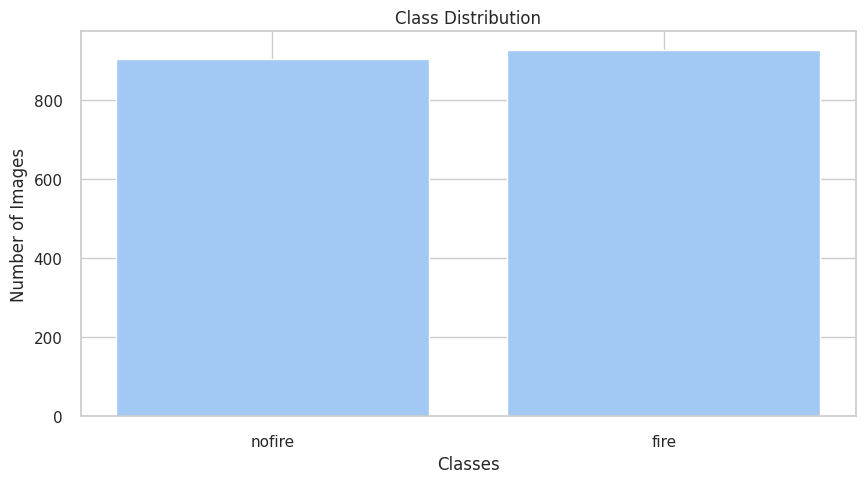

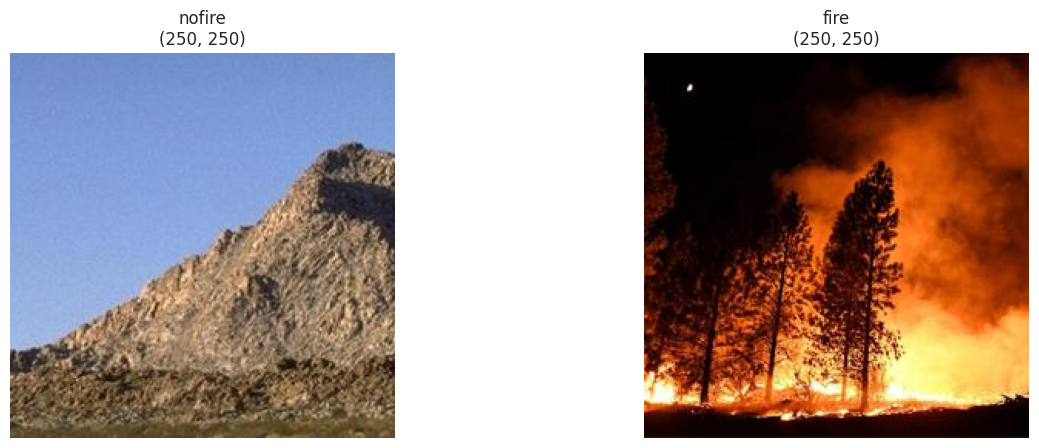


Test set:
Classes: ['nofire', 'fire']


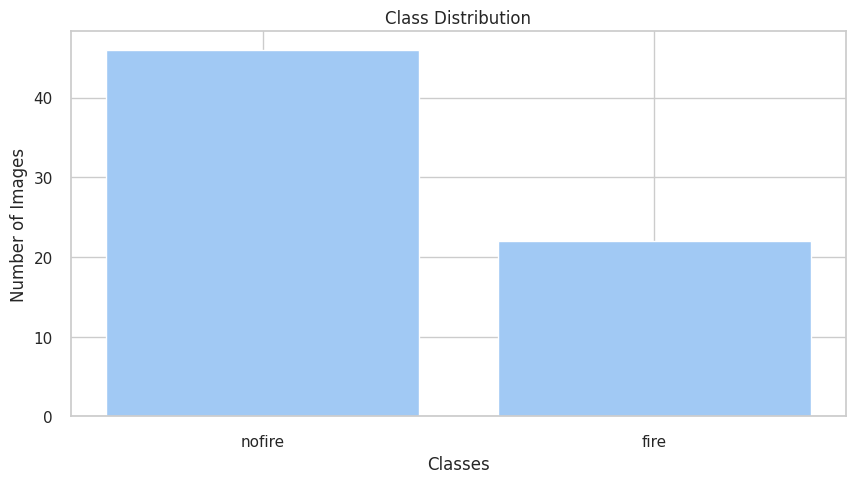

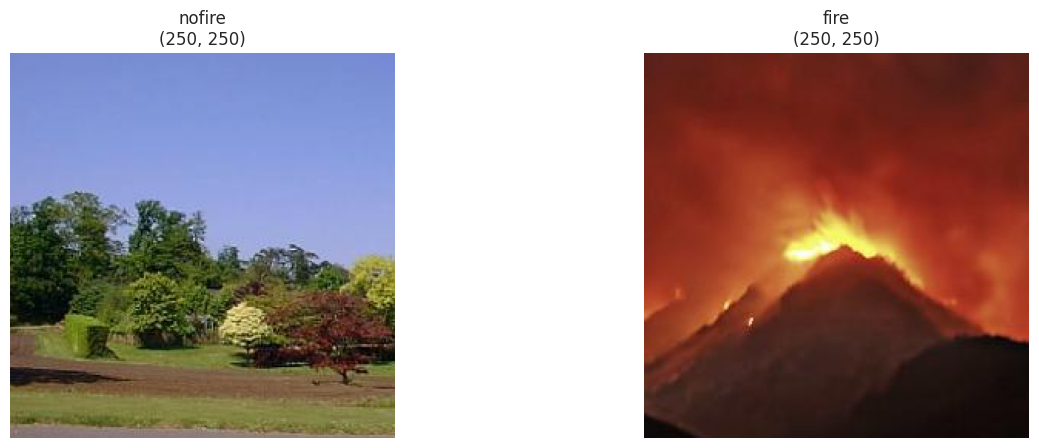

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to explore dataset
def explore_dataset(directory):
    classes = os.listdir(directory)
    print(f"Classes: {classes}")

    class_counts = {}
    sample_images = []

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        count = len(os.listdir(class_dir))
        class_counts[class_name] = count

        # Get a sample image from each class
        sample_img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
        sample_images.append((class_name, sample_img_path))

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

    # Display sample images
    plt.figure(figsize=(15, 5))
    for i, (class_name, img_path) in enumerate(sample_images):
        img = load_img(img_path)
        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(f'{class_name}\n{img.size}')
        plt.axis('off')
    plt.show()

    return class_counts

# Explore training and test datasets
print("Training set:")
train_class_counts = explore_dataset(train_dir)
print("\nTest set:")
test_class_counts = explore_dataset(test_dir)

Sample preprocessed images:


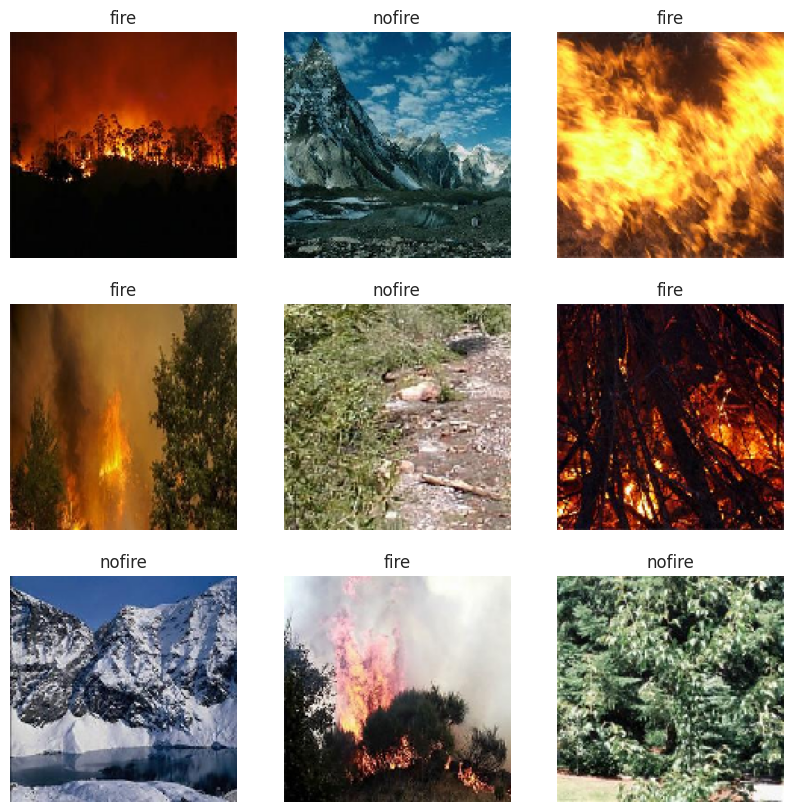

In [19]:
# Function to display batch of images
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title(class_names[int(label_batch[i])])
        plt.axis("off")

# Get a batch of training data
image_batch, label_batch = next(train_generator)
class_names = list(train_generator.class_indices.keys())

# Show preprocessed images
print("Sample preprocessed images:")
show_batch(image_batch, label_batch, class_names)

### Model Definition, Compilation, Training

#### Optimizers:Adam, SGD, RMSprop
#### Learning Rates:0.001, 0.01, 0.0001

In [42]:
# Function to define wildfire detection model
def build_wildfire_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(150, 150, 3)),  # Flatten 150x150x3 into 67,500 features
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),  # Prevent overfitting
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification (Fire/No Fire)
    ])
    return model

# Training configurations
optimizers = [Adam, SGD, RMSprop]
learning_rates = [0.001, 0.01, 0.0001]

history_dict = {}
trained_models = {}

# Training loop
for optimizer in optimizers:
    for lr in learning_rates:
        print(f"\nTraining with {optimizer.__name__}, lr={lr}")

        model = build_wildfire_model()
        model.compile(
            optimizer=optimizer(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
            verbose=1
        )

        history_dict[(optimizer.__name__, lr)] = history
        trained_models[(optimizer.__name__, lr)] = model

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_generator, verbose=2)
        print(f"Test accuracy for {optimizer.__name__} with learning rate {lr}: {test_acc:.4f}")


Training with Adam, lr=0.001
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.6719 - loss: 5.0134 - val_accuracy: 0.7781 - val_loss: 1.5128
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7896 - loss: 1.6916 - val_accuracy: 0.7644 - val_loss: 1.2911
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8569 - loss: 0.6662 - val_accuracy: 0.8384 - val_loss: 0.5681
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8838 - loss: 0.3726 - val_accuracy: 0.8384 - val_loss: 0.4859
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8628 - loss: 0.4518 - val_accuracy: 0.8301 - val_loss: 0.4110
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8955 - loss: 0.3023 - val_accuracy: 0.8712 - val_loss: 0.3175
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9047 - loss: 0.2546 - val_accuracy: 0.8247 - val_loss: 0.3837
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8935 - loss: 0.

## Classification Evaluation for Each model

### Classification Reports and Confusion Matrices


                             CLASSIFICATION REPORTS                             



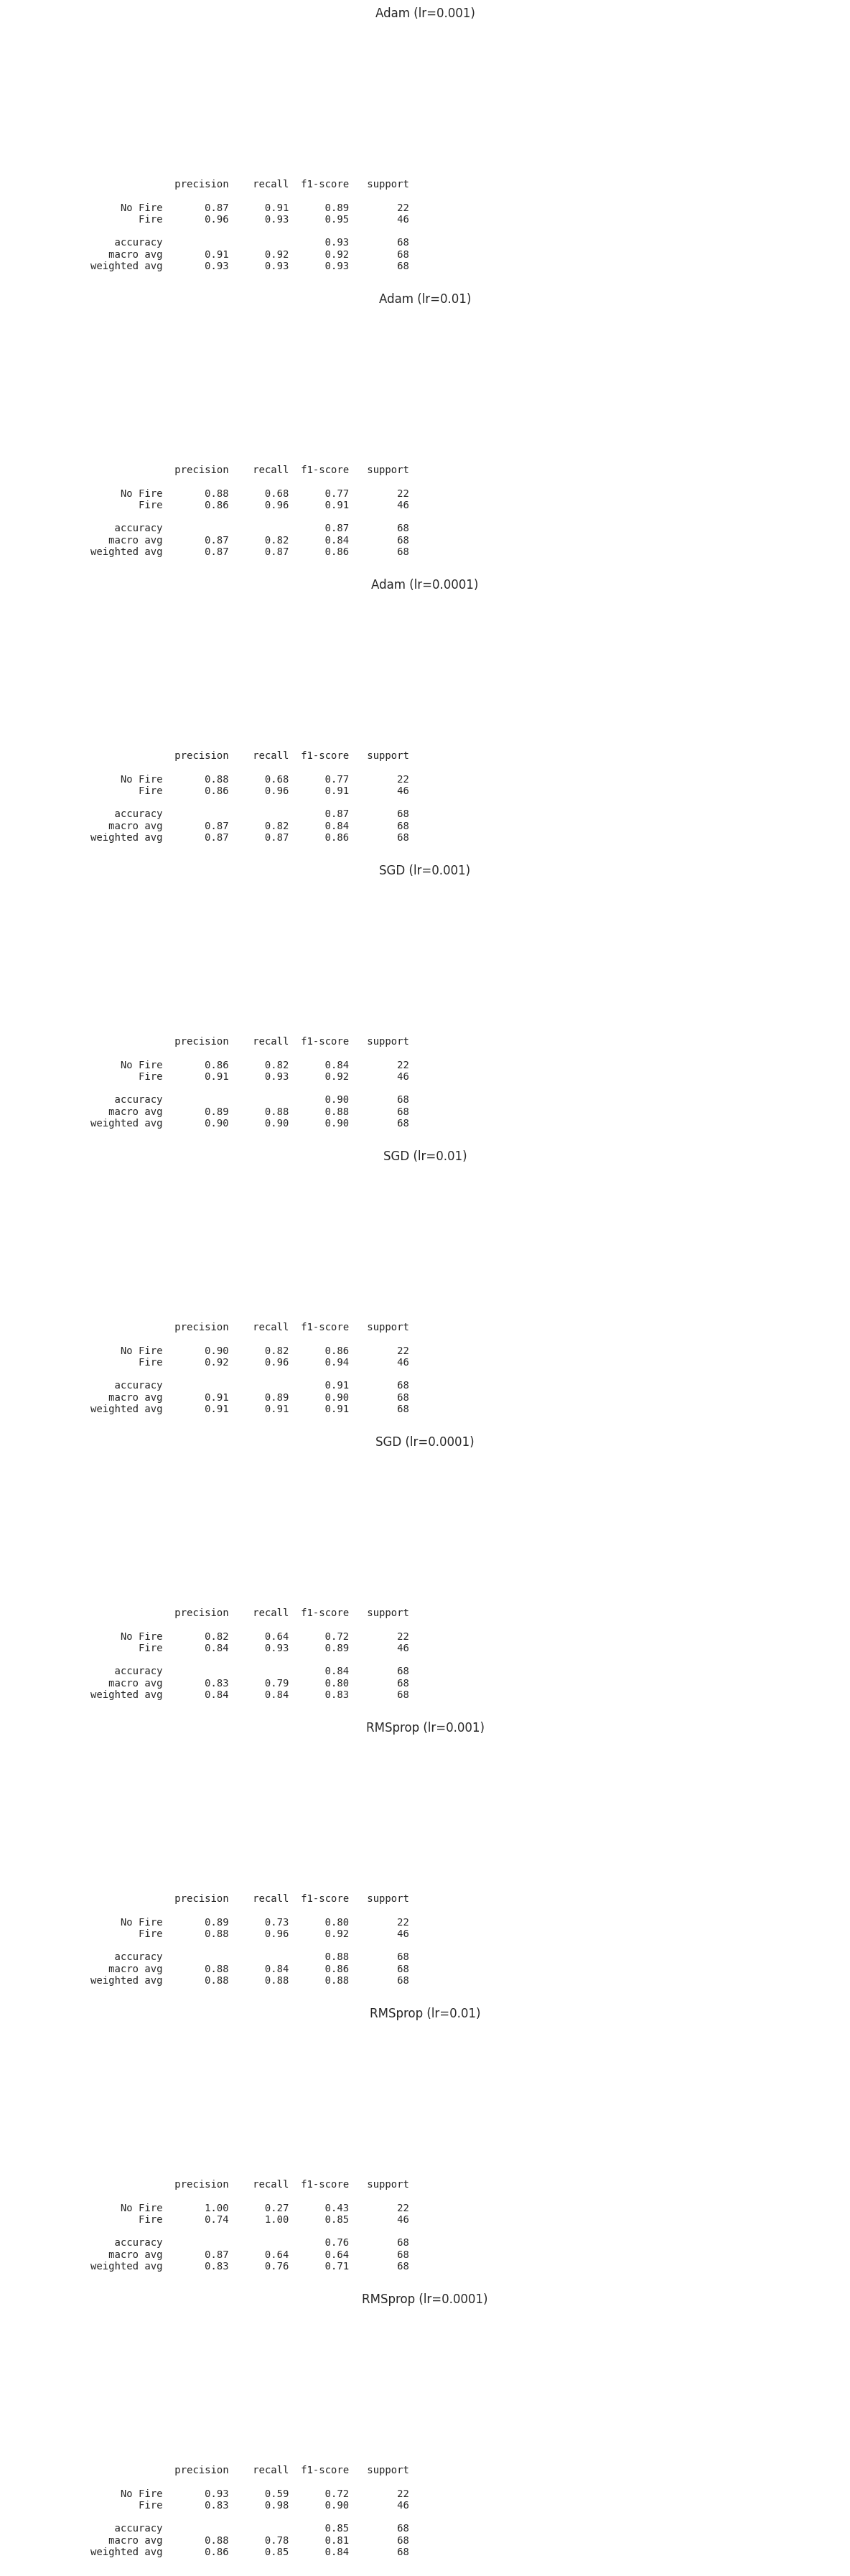


                               CONFUSION MATRICES                               



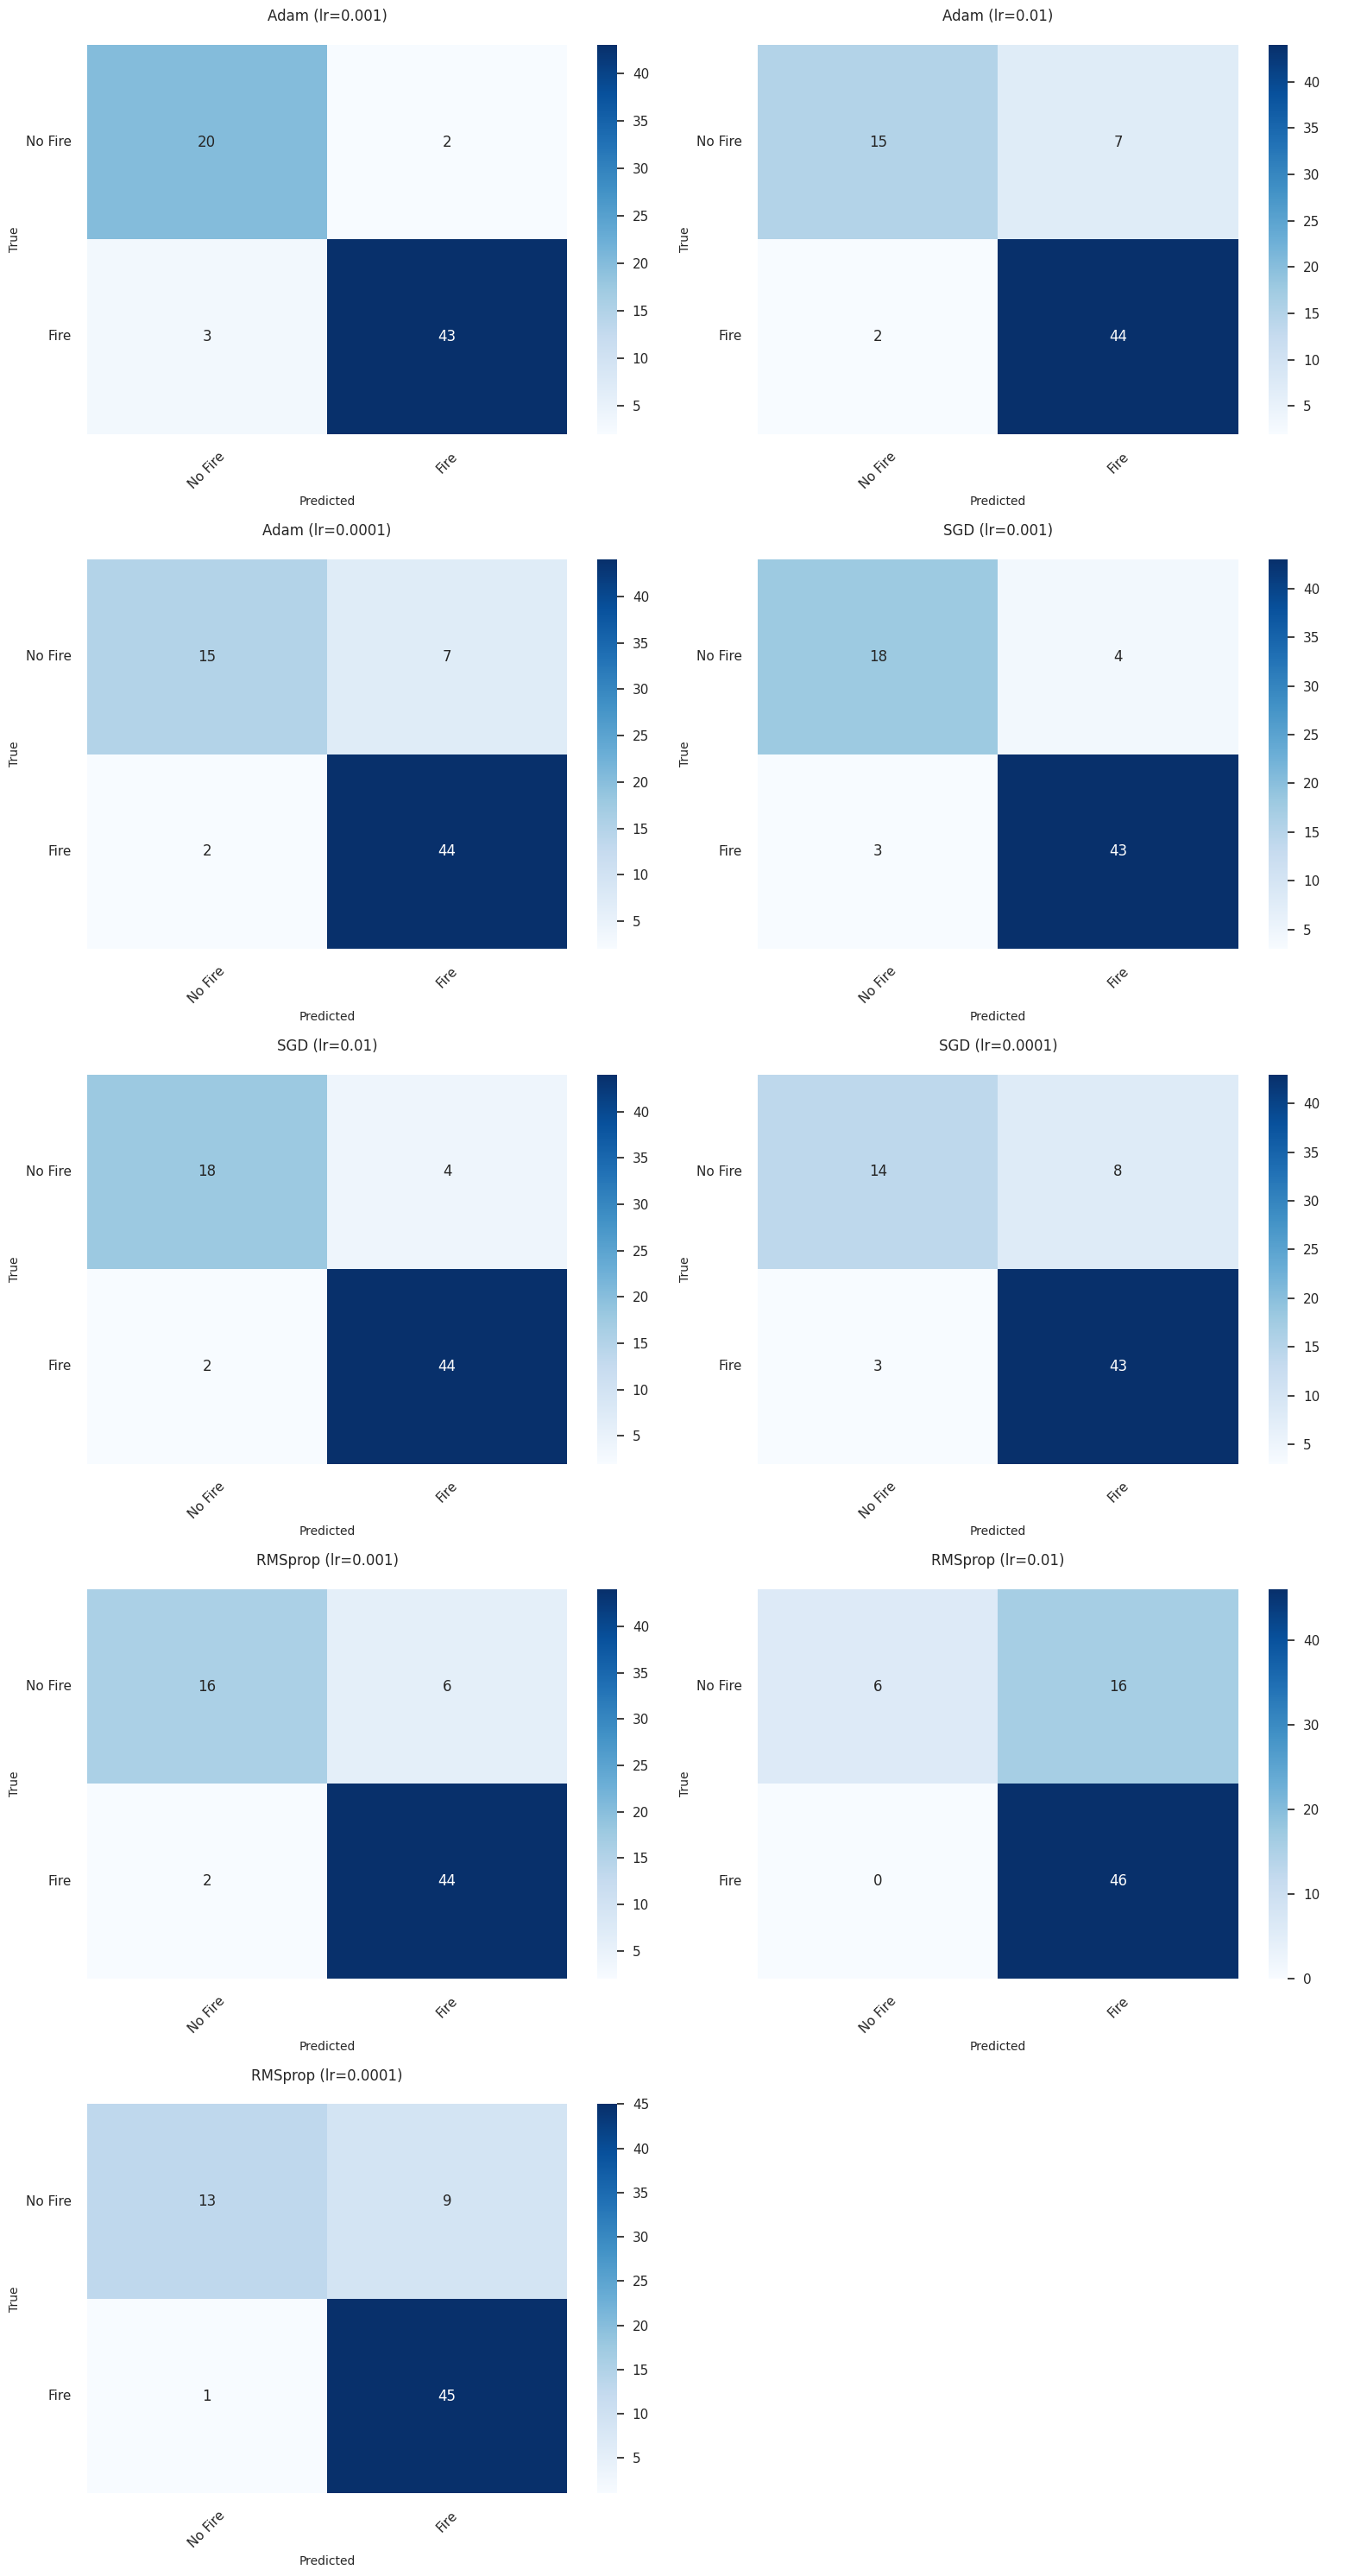

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

def print_report_matrix(models_dict, test_generator, class_names=['No Fire', 'Fire']):
    # Set visual style
    plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
    sns.set_theme(style="whitegrid")
    sns.set_palette("pastel")

    # Get true labels and predictions for all models
    test_generator.reset()
    y_true = test_generator.classes

    # ====================
    # Classification Reports
    # ====================
    print("\n" + "="*80)
    print("CLASSIFICATION REPORTS".center(80))
    print("="*80 + "\n")

    plt.figure(figsize=(12, 4*len(models_dict)))

    for i, (model_name, model) in enumerate(models_dict.items(), 1):
        test_generator.reset()
        y_pred = model.predict(test_generator, verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int)

        report = classification_report(y_true, y_pred_classes,
                                    target_names=class_names)

        ax = plt.subplot(len(models_dict), 1, i)
        ax.text(0.1, 0.1, report, fontfamily='monospace', fontsize=10, va='top')
        ax.set_title(f"{model_name[0]} (lr={model_name[1]})", pad=20, fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # =================
    # Confusion Matrices
    # =================
    print("\n" + "="*80)
    print("CONFUSION MATRICES".center(80))
    print("="*80 + "\n")

    n_models = len(models_dict)
    n_cols = min(2, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (model_name, model) in enumerate(models_dict.items()):
        test_generator.reset()
        y_pred = model.predict(test_generator, verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_true, y_pred_classes)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   ax=axes[i])

        axes[i].set_title(f"{model_name[0]} (lr={model_name[1]})", pad=20, fontsize=12)
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('True', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
print_report_matrix(trained_models, test_generator)

### Loss and Accuracy Curves

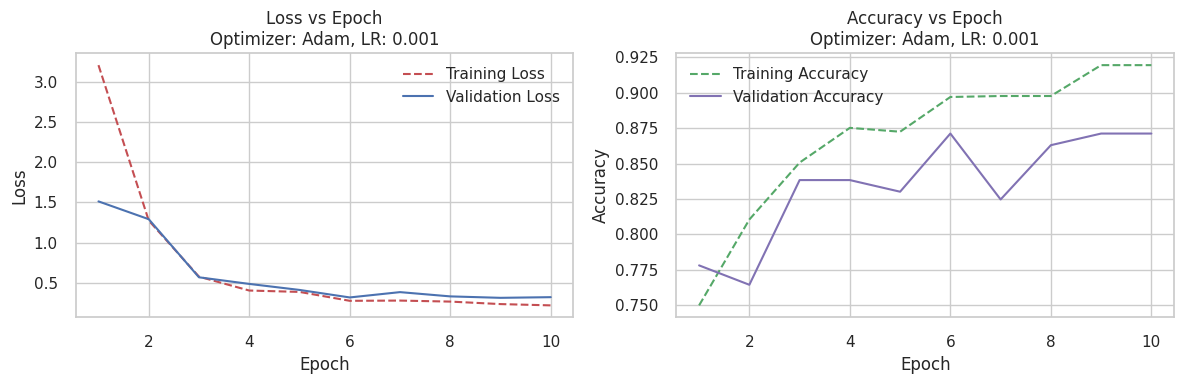

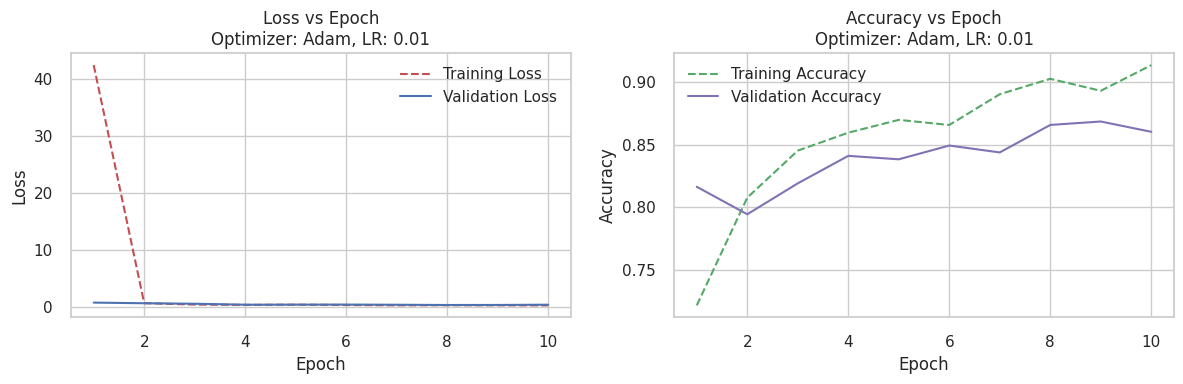

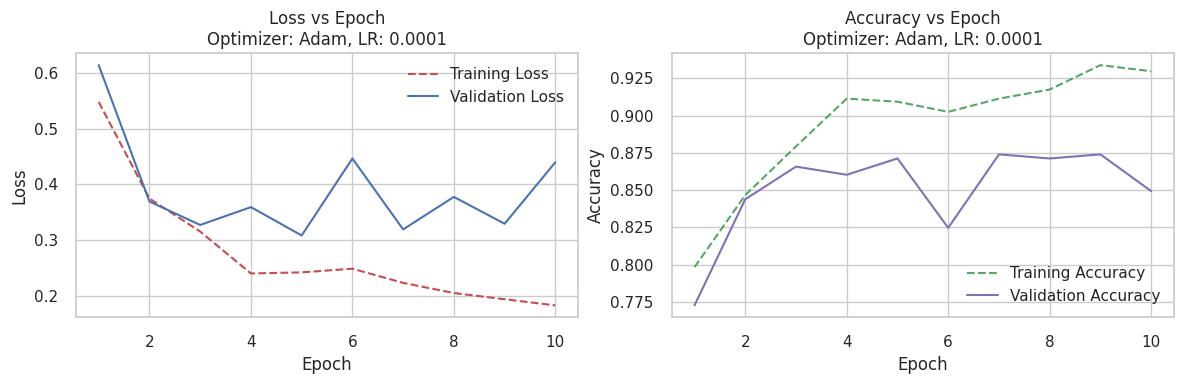

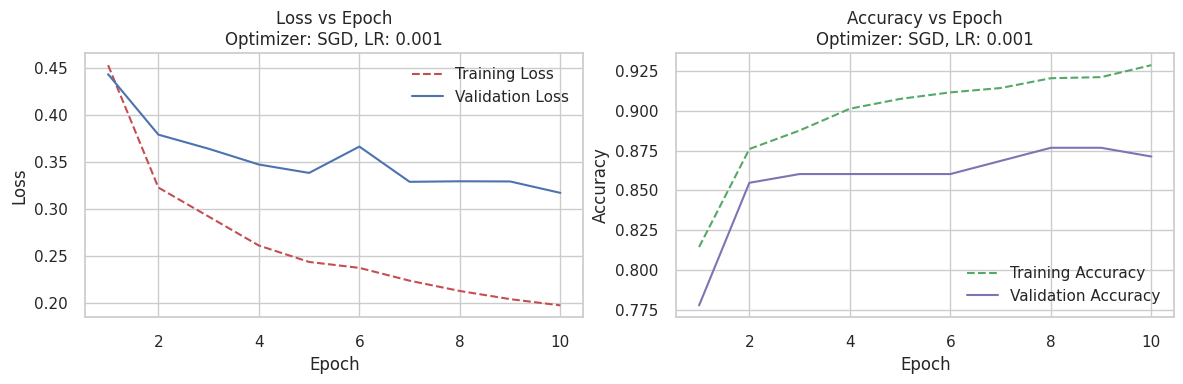

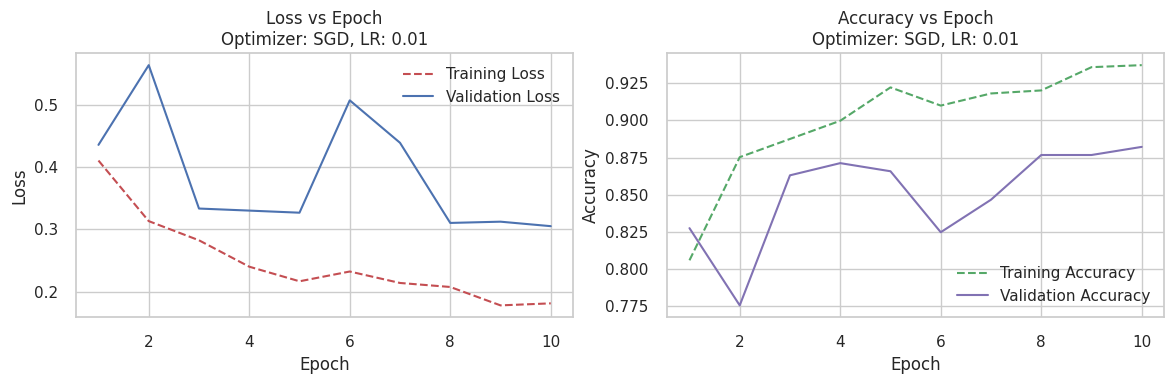

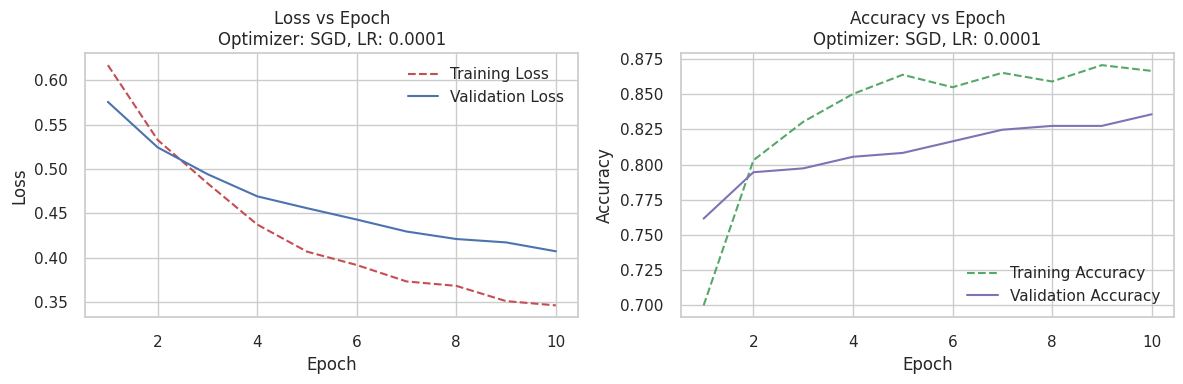

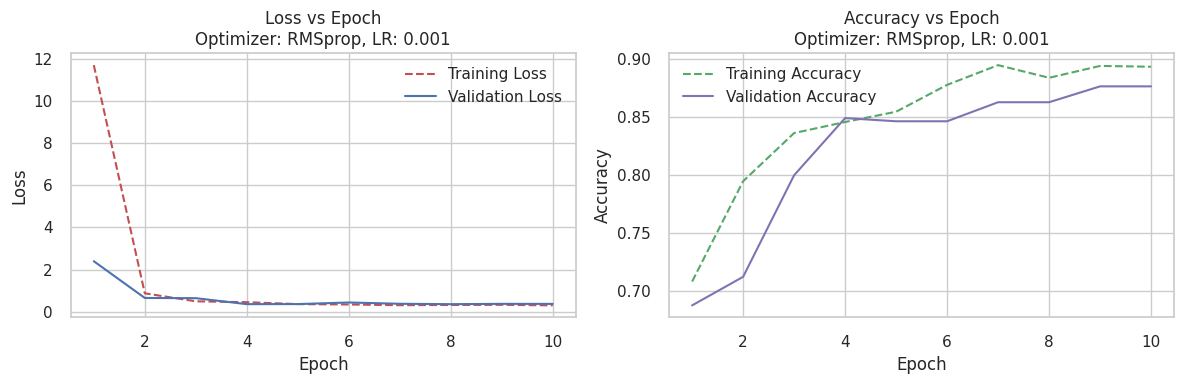

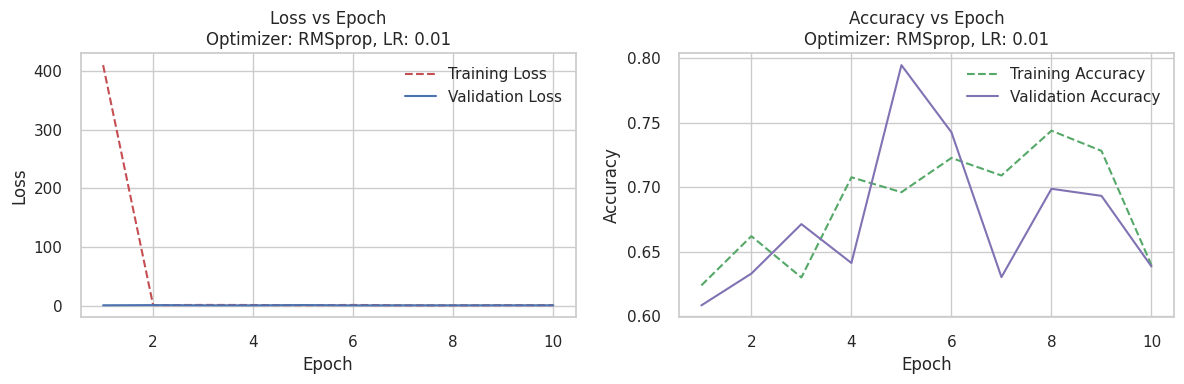

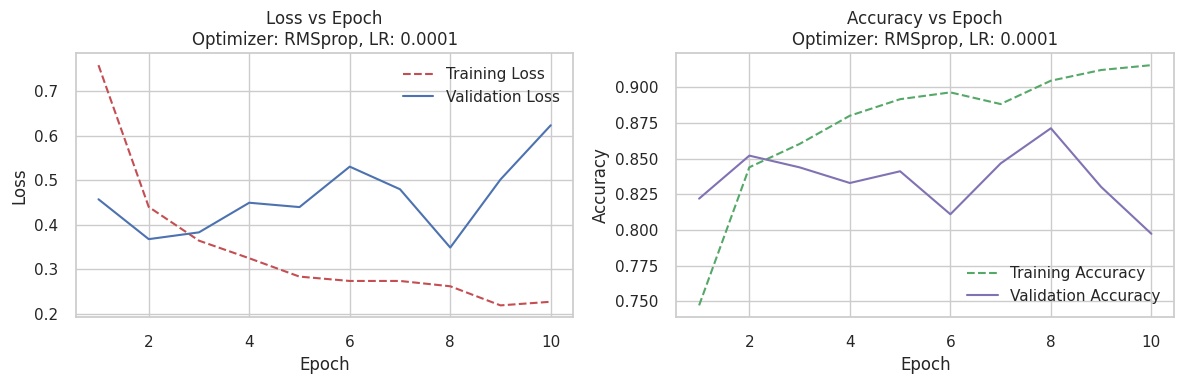

In [44]:
# Plot Loss and Accuracy Curve for each model
for key, history in history_dict.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    epochs = range(1, len(history.history['loss']) + 1)
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    validation_acc = history.history['val_accuracy']

    axes[0].plot(epochs, training_loss, 'r--', label='Training Loss')
    axes[0].plot(epochs, validation_loss, 'b-', label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Loss vs Epoch\nOptimizer: {key[0]}, LR: {key[1]}')
    axes[0].legend()

    axes[1].plot(epochs, training_acc, 'g--', label='Training Accuracy')
    axes[1].plot(epochs, validation_acc, 'm-', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'Accuracy vs Epoch\nOptimizer: {key[0]}, LR: {key[1]}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### ROC-AUC Curves

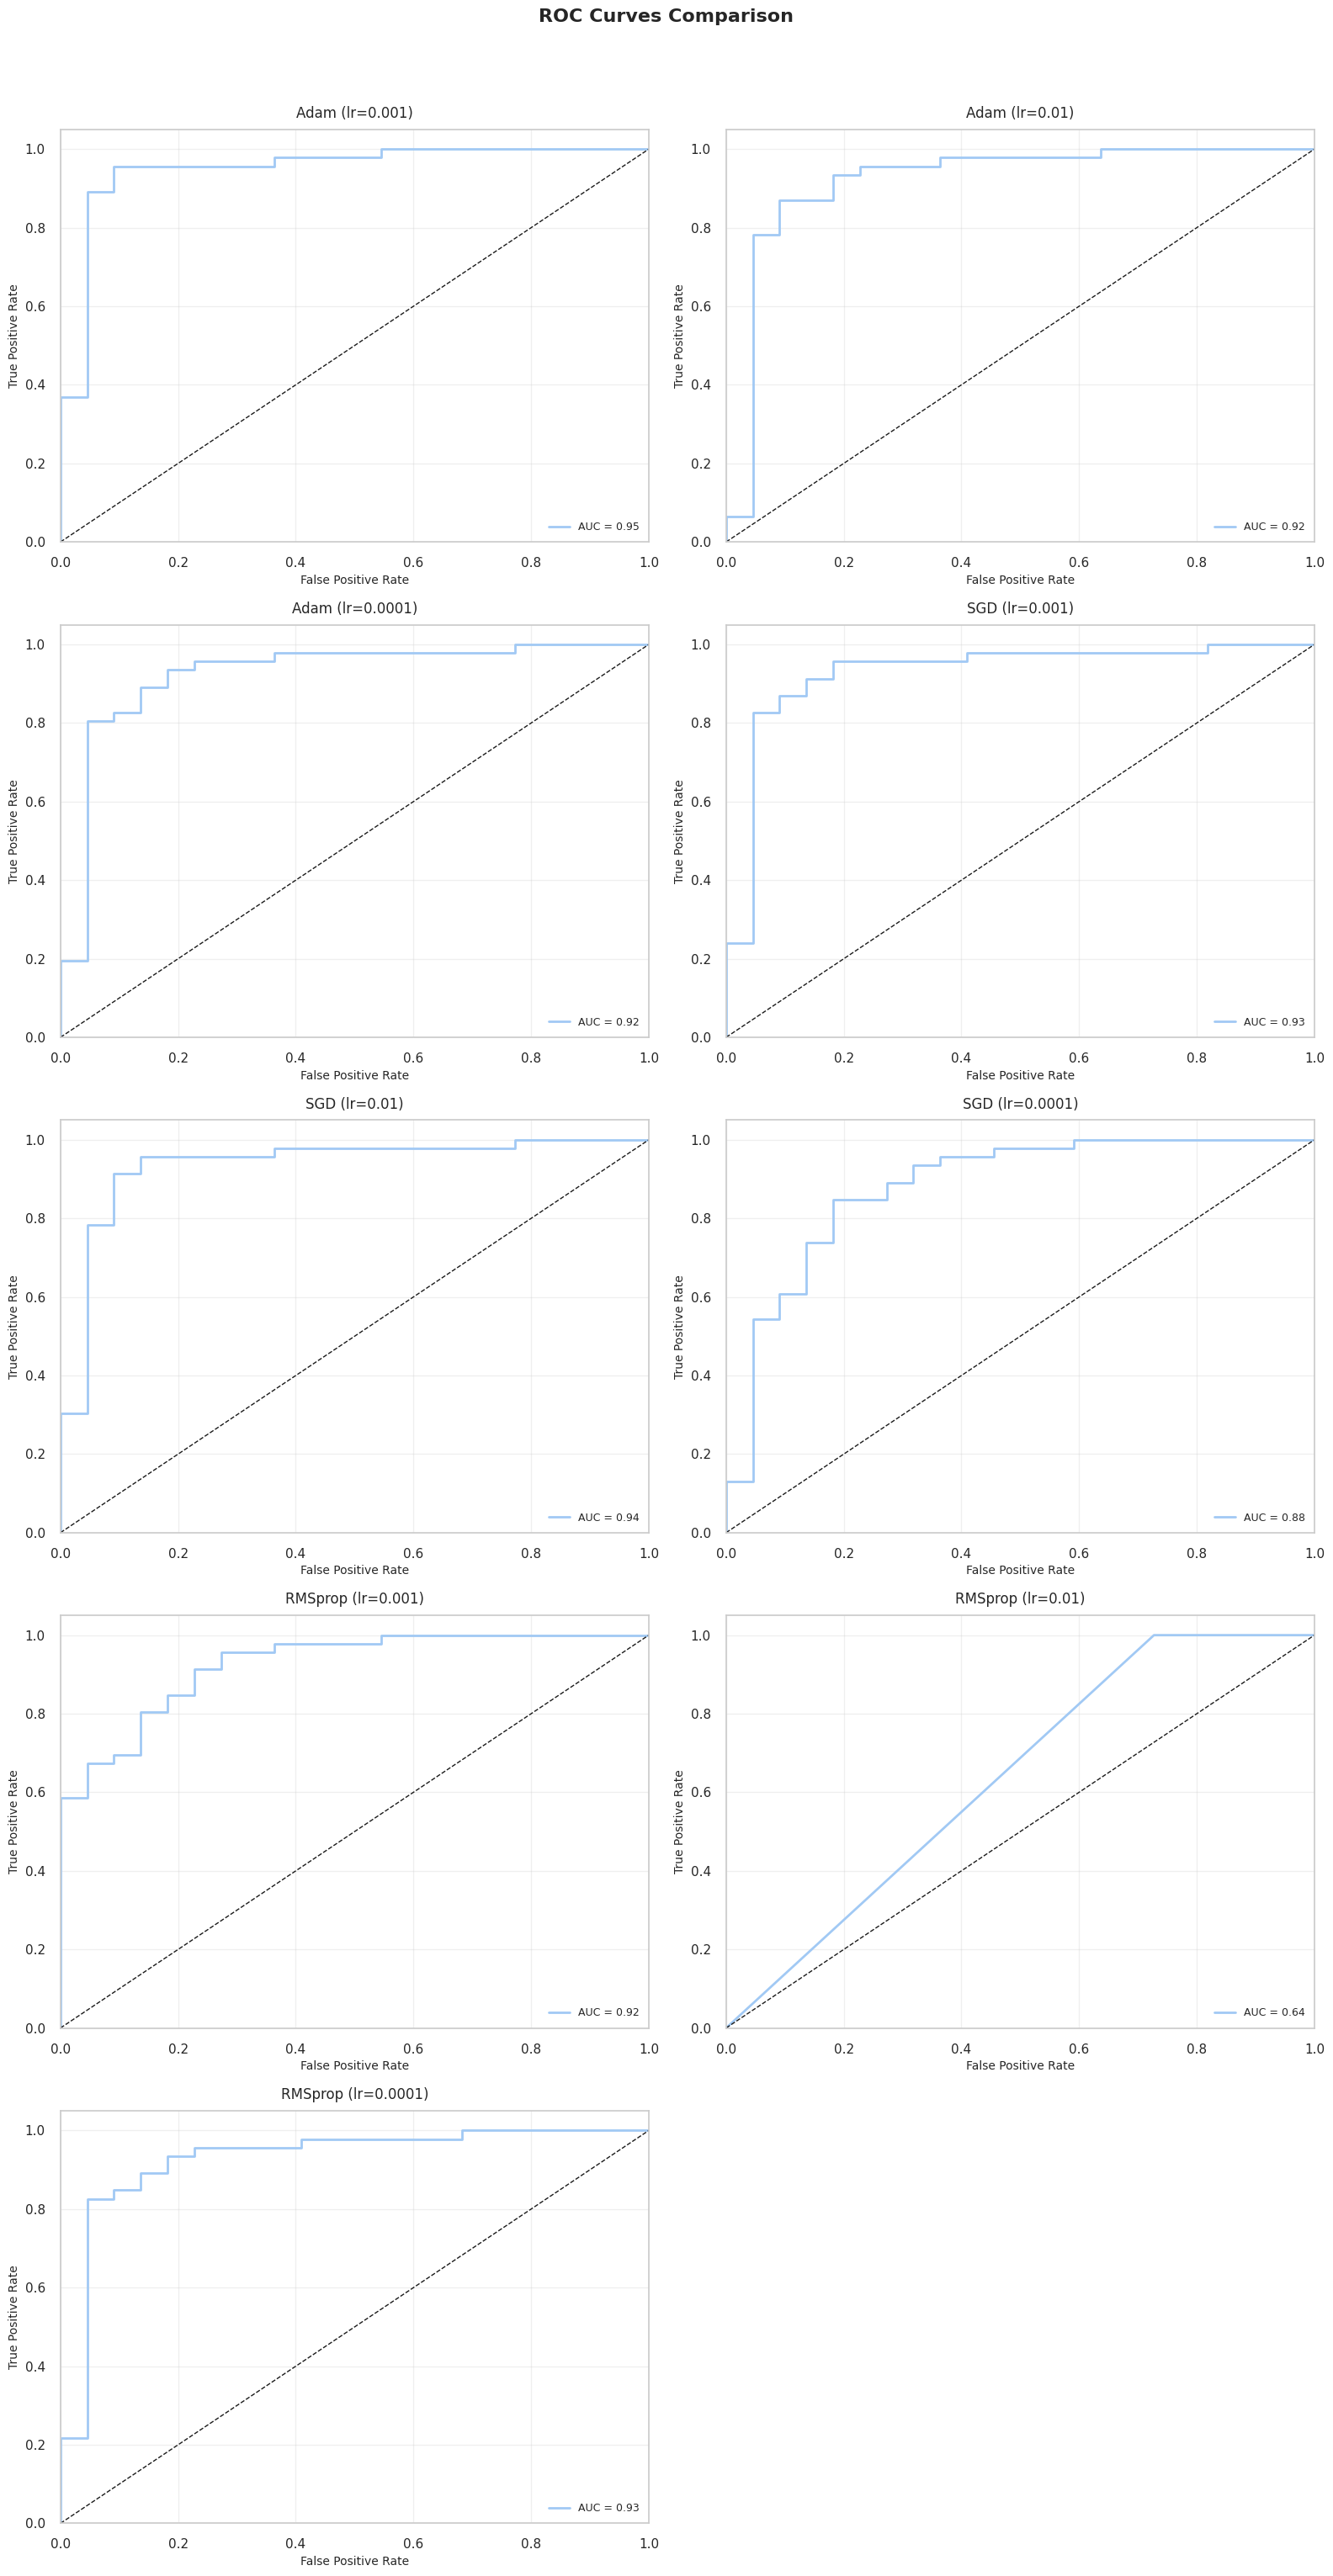

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

def plot_roc_curves(models, test_generator):

    # Calculate grid size
    n_models = len(models)
    n_cols = 2  # Number of columns in the grid
    n_rows = ceil(n_models / n_cols)

    # Create figure
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    fig.suptitle('ROC Curves Comparison', y=1.02, fontsize=16, fontweight='bold')

    # If only one model, convert axs to array for consistent handling
    if n_models == 1:
        axs = np.array([axs])

    # Flatten axes array for easy iteration
    axs = axs.flatten()

    # Get true labels
    test_generator.reset()
    y_true = test_generator.classes

    # Plot ROC curves for each model
    for ax, (model_name, model) in zip(axs, models.items()):
        # Get predictions
        test_generator.reset()
        y_prob = model.predict(test_generator, verbose=0)

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')

        # Formatting
        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)

        # Use model name as title
        title = f'{model_name[0]} (lr={model_name[1]})'
        ax.set_title(title, fontsize=12, pad=10)

        ax.grid(alpha=0.3)
        ax.legend(loc='lower right', fontsize=9)

    # Hide any unused subplots
    for i in range(n_models, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_roc_curves(trained_models, test_generator)

## Comparative Analysis of all the models

### Accuracy and Loss Curves per Optimizer

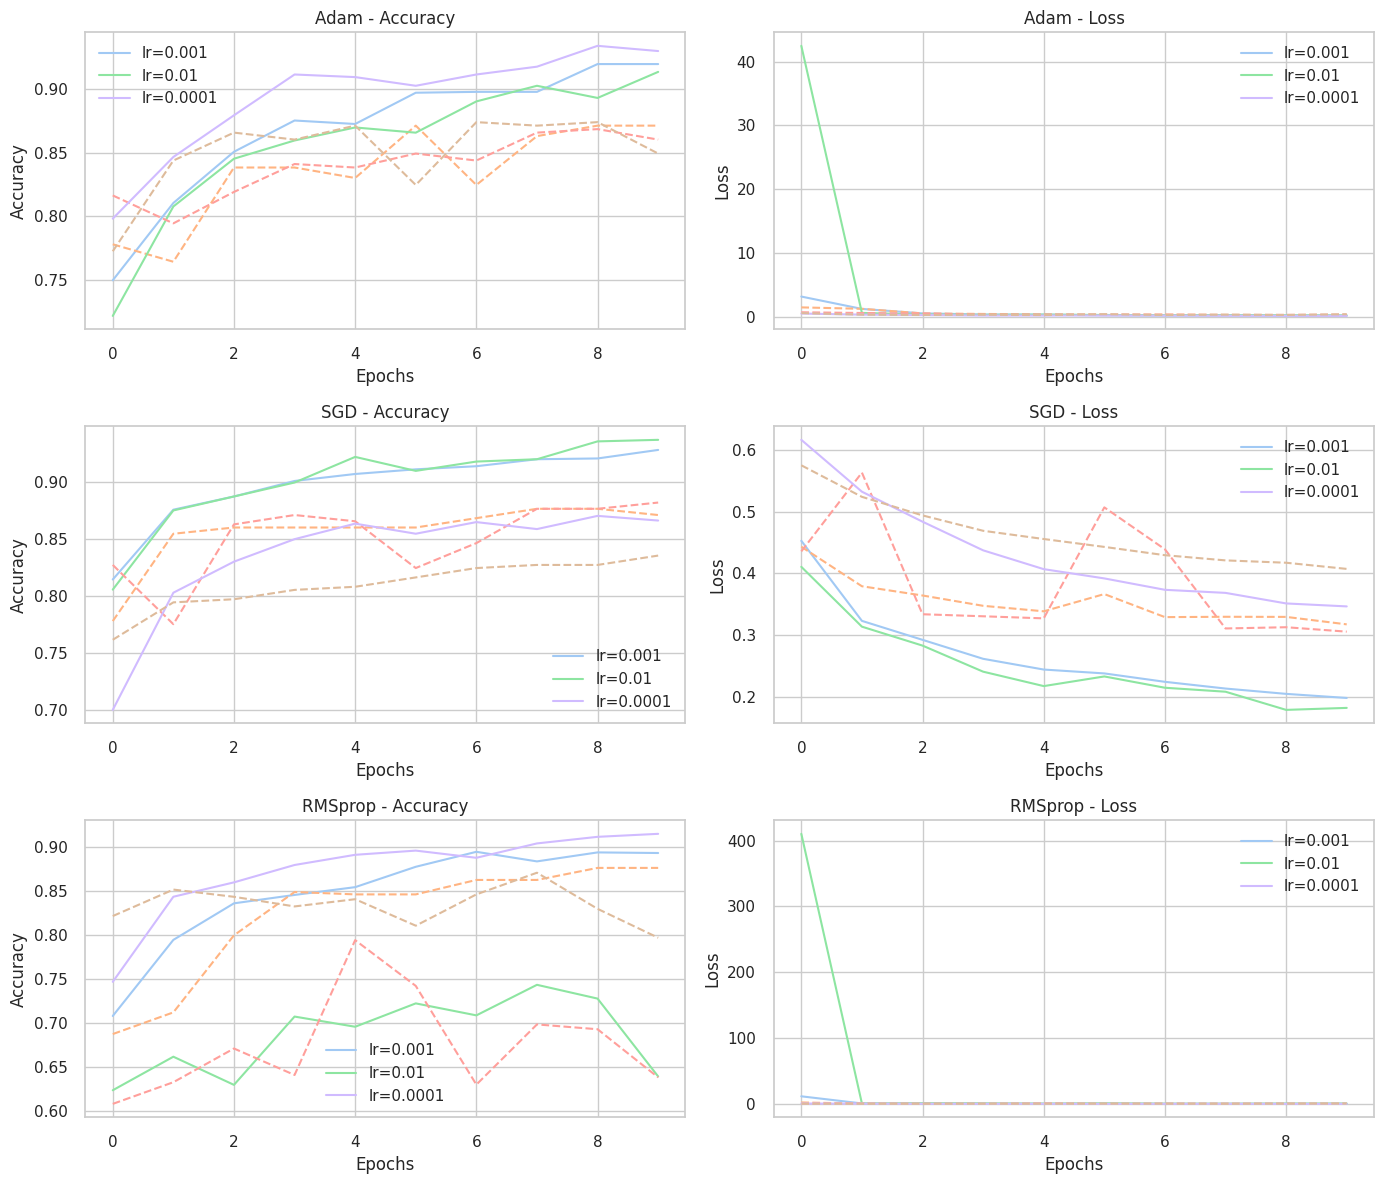

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(14, 12))
optimizer_names = ['Adam', 'SGD', 'RMSprop']

for i, opt_name in enumerate(optimizer_names):
    ax_acc = axs[i][0]
    ax_loss = axs[i][1]
    ax_acc.set_title(f'{opt_name} - Accuracy')
    ax_loss.set_title(f'{opt_name} - Loss')

    for (opt, lr), history in history_dict.items():
        if opt == opt_name:
            label = f"lr={lr}"
            ax_acc.plot(history.history['accuracy'], label=label)
            ax_acc.plot(history.history['val_accuracy'], linestyle='--')
            ax_loss.plot(history.history['loss'], label=label)
            ax_loss.plot(history.history['val_loss'], linestyle='--')

    ax_acc.set_ylabel('Accuracy')
    ax_loss.set_ylabel('Loss')
    ax_acc.set_xlabel('Epochs')
    ax_loss.set_xlabel('Epochs')
    ax_acc.grid(True)
    ax_loss.grid(True)
    ax_acc.legend()
    ax_loss.legend()

plt.tight_layout()
plt.show()

### Validation Accuracy Comparison per Optimizer

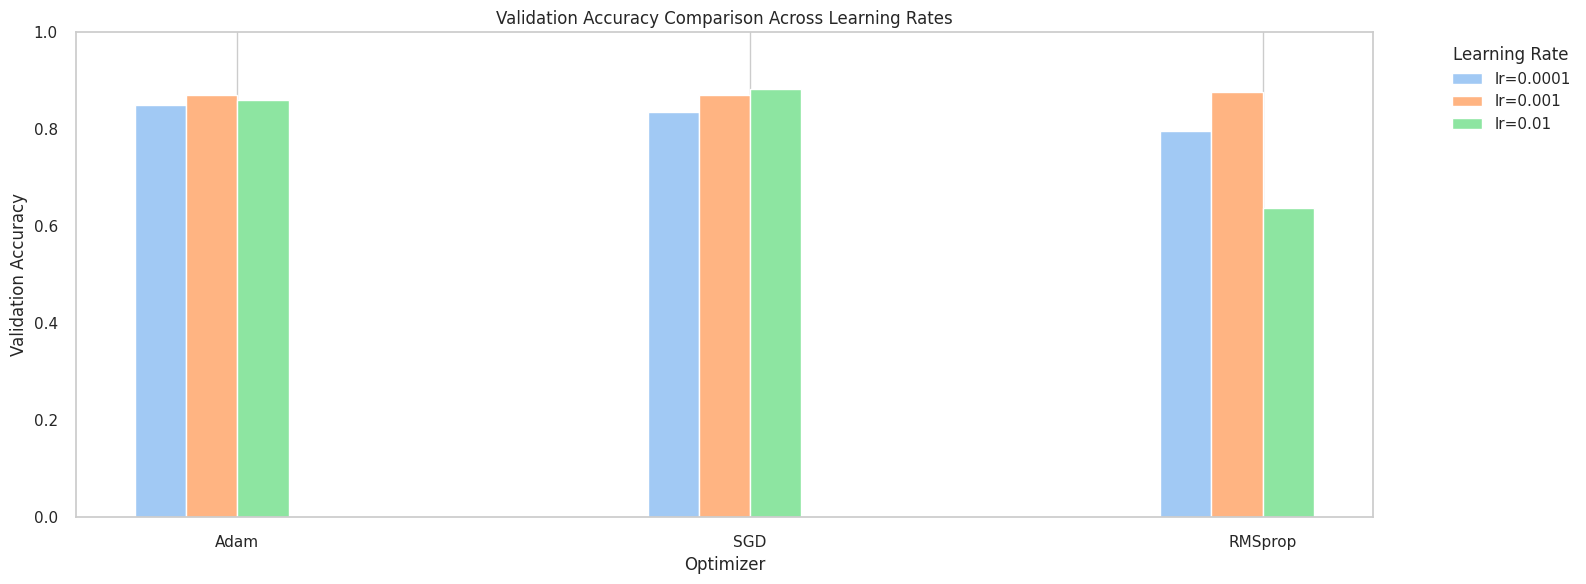

In [47]:
# Bar Plot: Final Validation Accuracy
bar_data = {}

for (opt, lr), history in history_dict.items():
    if opt not in bar_data:
        bar_data[opt] = {}
    bar_data[opt][f"lr={lr}"] = history.history['val_accuracy'][-1]

optimizers = list(bar_data.keys())
configs = sorted({cfg for opt in bar_data.values() for cfg in opt})
val_acc_matrix = [[bar_data[opt].get(cfg, 0) for cfg in configs] for opt in optimizers]

x = np.arange(len(optimizers))
width = 0.1

plt.figure(figsize=(16, 6))
for i, cfg in enumerate(configs):
    plt.bar(x + i * width, [val_acc_matrix[j][i] for j in range(len(optimizers))], width=width, label=cfg)

plt.ylabel('Validation Accuracy')
plt.xlabel('Optimizer')
plt.title('Validation Accuracy Comparison Across Learning Rates')
plt.xticks(x + width * (len(configs) / 2), optimizers)
plt.ylim([0, 1])
plt.legend(title='Learning Rate', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### ROC-AUC curves per Optimizer

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


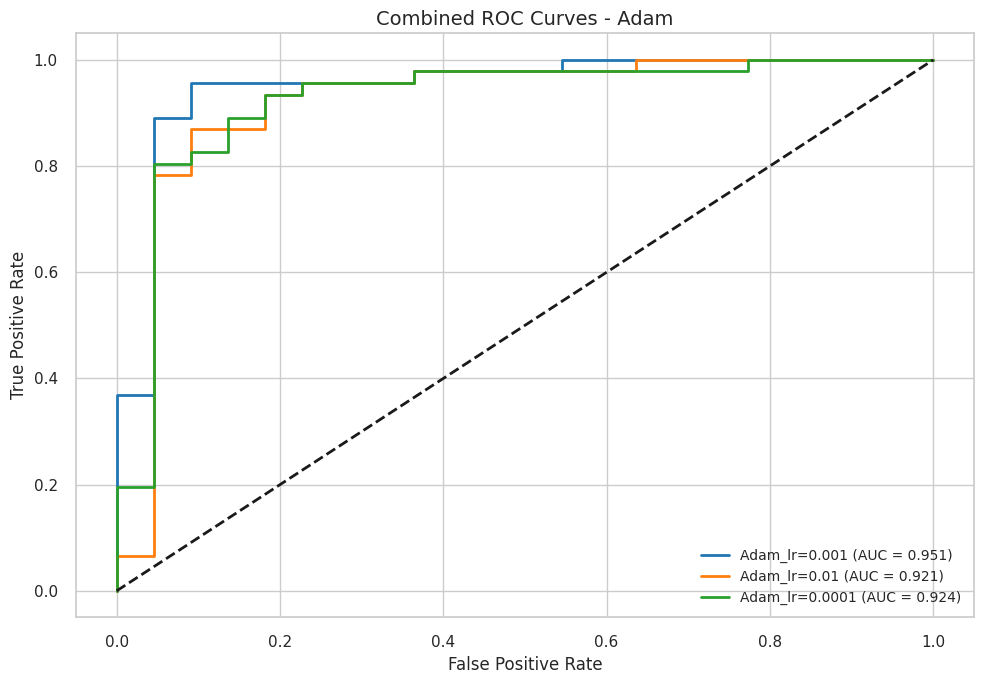

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


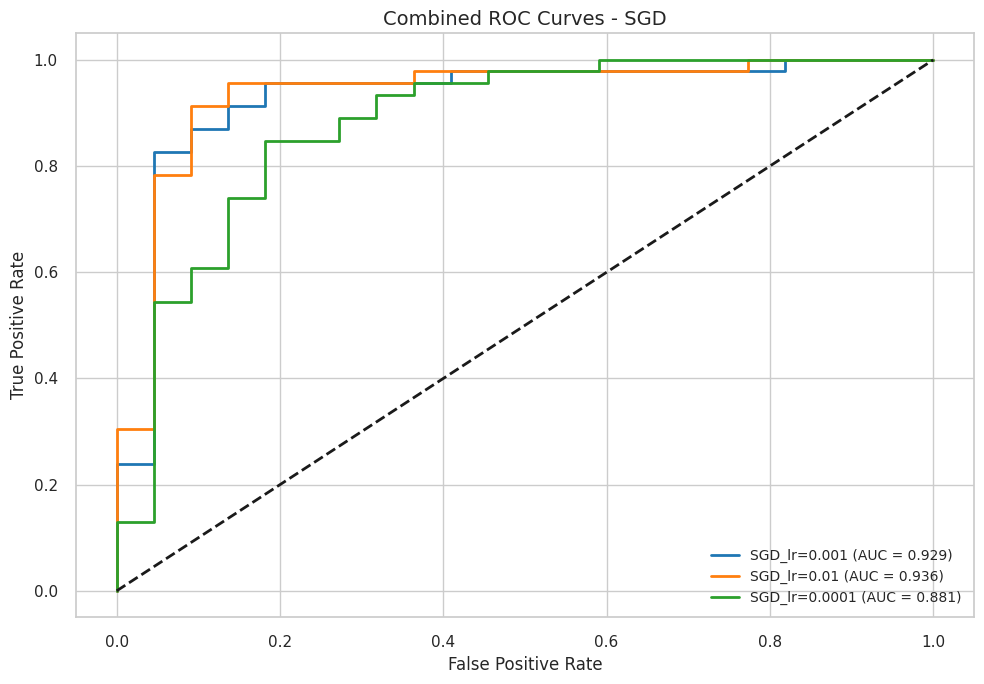

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


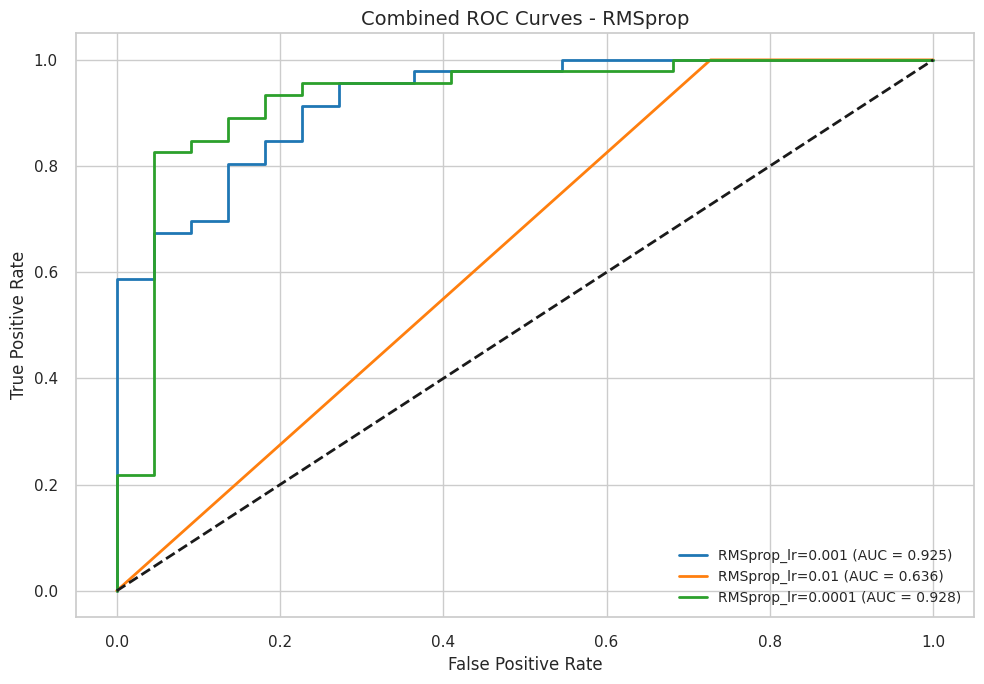

In [48]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Group models by optimizer
optimizer_groups = {}
for (opt, lr), model in trained_models.items():
    if opt not in optimizer_groups:
        optimizer_groups[opt] = []
    optimizer_groups[opt].append((f"{opt}_lr={lr}", model))

# Get true labels
test_generator.reset()
y_true = test_generator.classes

for optimizer, models_list in optimizer_groups.items():
    plt.figure(figsize=(10, 7))
    colors = cycle(plt.cm.tab10.colors)

    for label, model in models_list:
        test_generator.reset()
        y_score = model.predict(test_generator)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=next(colors), label=f"{label} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f"Combined ROC Curves - {optimizer}", fontsize=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Comparitive Accuracy and Loss curves of all models

<ipython-input-49-aba9efafa989>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


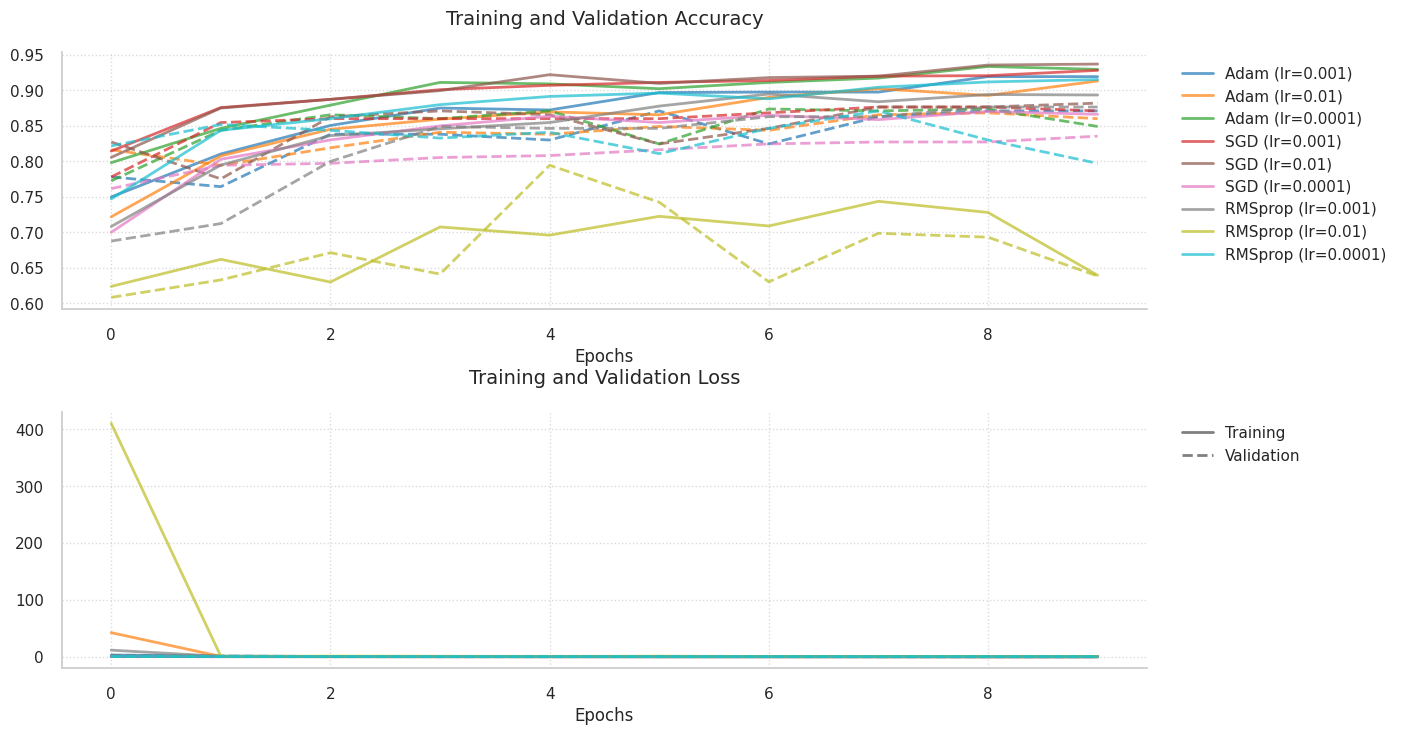

In [49]:
import numpy as np

plt.figure(figsize=(14, 8))

gs = plt.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.4, wspace=0.3)
ax_acc = plt.subplot(gs[0, :])
ax_loss = plt.subplot(gs[1, :])

colors = plt.cm.tab10(np.linspace(0, 1, len(history_dict)))

for i, ((opt, lr), history) in enumerate(history_dict.items()):
    label = f"{opt} (lr={lr})"
    ax_acc.plot(history.history['accuracy'], color=colors[i], linestyle='-', linewidth=2, alpha=0.7, label=label)
    ax_acc.plot(history.history['val_accuracy'], color=colors[i], linestyle='--', linewidth=2, alpha=0.7)

    ax_loss.plot(history.history['loss'], color=colors[i], linestyle='-', linewidth=2, alpha=0.7, label=label)
    ax_loss.plot(history.history['val_loss'], color=colors[i], linestyle='--', linewidth=2, alpha=0.7)

ax_acc.set_title('Training and Validation Accuracy', pad=20, fontsize=14)
ax_loss.set_title('Training and Validation Loss', pad=20, fontsize=14)

for ax in [ax_acc, ax_loss]:
    ax.set_xlabel('Epochs', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

handles, labels = ax_acc.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
ax_acc.legend(handles[:len(unique_labels)], unique_labels, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', linestyle='-', lw=2),
                Line2D([0], [0], color='gray', linestyle='--', lw=2)]
ax_loss.legend(custom_lines, ['Training', 'Validation'], bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

### Classification Metrics comparison in table format

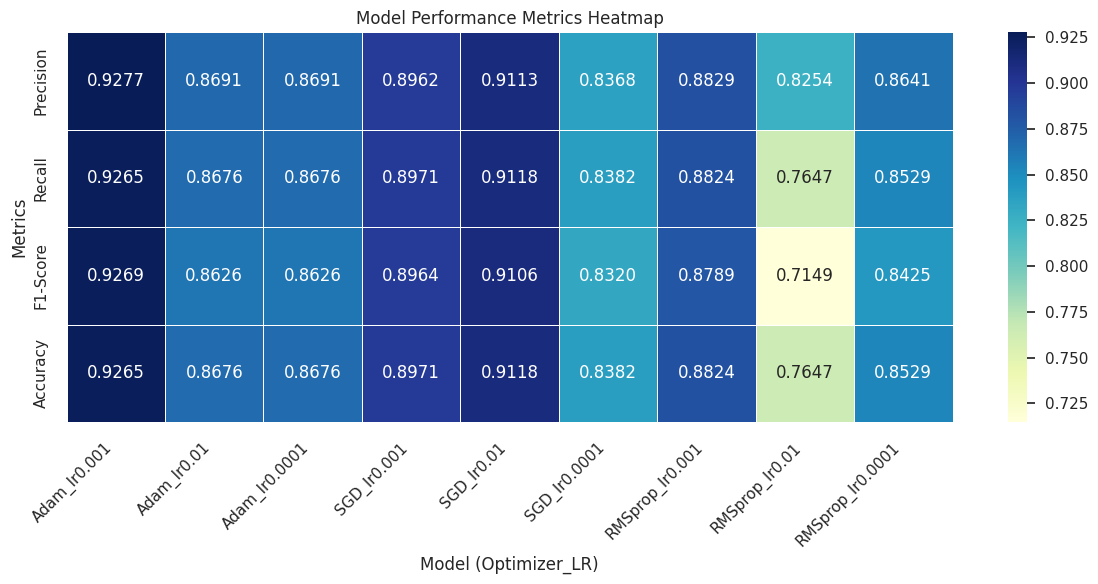


================= BEST MODEL: Adam_lr0.001 =================
Accuracy: 0.9265
Precision: 0.9277
Recall: 0.9265
F1-Score: 0.9269

Saved best model to: best_model_Adam_lr0.001.h5


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Initialize dictionary to store metrics
model_metrics = {}
best_model = None
best_accuracy = 0

# Class names
class_names = ['No Fire', 'Fire']

# Analyze each model
for key, model in trained_models.items():
    test_generator.reset()
    y_pred = model.predict(test_generator, verbose=0)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = test_generator.classes

    # Get classification report
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

    # Store metrics
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    accuracy = report['accuracy']

    model_name = f"{key[0]}_lr{key[1]}"
    model_metrics[model_name] = [precision, recall, f1, accuracy]

    # Track best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name

# Create DataFrame for heatmap
metrics_df = pd.DataFrame(model_metrics, index=['Precision', 'Recall', 'F1-Score', 'Accuracy'])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="YlGnBu", linewidths=0.5)
plt.title("Model Performance Metrics Heatmap")
plt.ylabel("Metrics")
plt.xlabel("Model (Optimizer_LR)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print best model info
print("\n" + "="*60)
print(f" BEST MODEL: {best_model_name} ".center(60, "="))
print("="*60)
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {metrics_df[best_model_name]['Precision']:.4f}")
print(f"Recall: {metrics_df[best_model_name]['Recall']:.4f}")
print(f"F1-Score: {metrics_df[best_model_name]['F1-Score']:.4f}")
print("="*60)

# Save best model
best_model.save(f"best_model_{best_model_name}.h5")
print(f"\nSaved best model to: best_model_{best_model_name}.h5")

### Testing the best performing Model

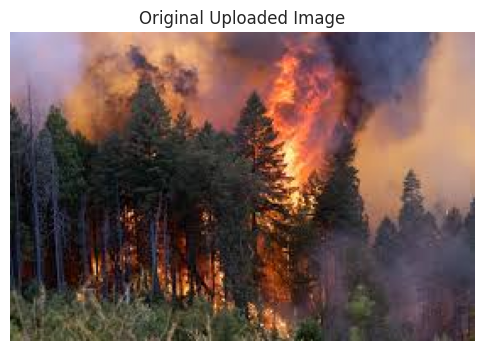

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Prediction Results:
Predicted Class: Fire
Confidence: 86.41%


In [53]:
import cv2

def upload_and_predict(file_path, model):
    if file_path:
        # Load image
        image = cv2.imread(file_path)
        if image is None:
            print("Error loading image")
            return

        # Display original image first
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Uploaded Image")
        plt.axis('off')
        plt.show()

        # Preprocess image
        image = cv2.resize(image, IMG_SIZE)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)

        # Make prediction
        prediction = model.predict(image)
        predicted_class = "Fire" if prediction > 0.5 else "No Fire"
        confidence = prediction[0][0] * 100 if predicted_class == "Fire" else (1 - prediction[0][0]) * 100

        print(f"\nPrediction Results:")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
    else:
        print("No file selected.")

upload_and_predict("/content/wildfireTest1.jpeg", best_model)


## Conclusion:
Based on the model performance metrics heatmap trained on the wildfire dataset, it is evident that the Adam optimizer with a learning rate of 0.001 consistently outperformed other configurations across all evaluation metrics—precision (0.9277), recall (0.9265), F1-score (0.9269), and accuracy (0.9265). While SGD with a learning rate of 0.01 also demonstrated competitive results, RMSprop generally showed lower performance, particularly with higher learning rates (e.g., RMSprop_lr0.01 with an F1-score of 0.7149). These findings highlight the critical impact of optimizer choice and learning rate tuning in achieving robust and reliable classification performance for wildfire-related data, and suggest Adam with lr=0.001 as the optimal configuration for this task.